In [1]:
from PositionManager import PositionManager
from Structure import Structure
import pandas as pd
import cProfile
pm = PositionManager(True)

In [2]:
csv_file_path = 'historical_data.csv'  # 替换为你的CSV文件路径
from fake_data import *
csv_data = load_csv_data(csv_file_path)

In [3]:
current_index = 0
contract = 'TSLA'
while True:
    bars, current_index = fake_fetch_minute_data(contract, csv_data, current_index)
    if bars is None: break
    bars = pd.DataFrame(bars)
    structure = Structure()
    # structure.cal(bars)
    current_time = bars.iloc[-1]["date"]
    pm.update(structure, bars, current_time)

平仓信号：持有时间超限
平仓信号：达到亏损上限
平仓信号：持有时间超限
平仓信号：持有时间超限


In [4]:
pd.DataFrame(pm.trade_log)

,symbol,open_or_close,direction,amount,date
0,某股票,开仓,Bought,100,2025-01-07 10:37:00-05:00
1,某股票,平仓,Sold,100,2025-01-07 11:03:00-05:00
2,某股票,开仓,Sold,-100,2025-01-07 11:30:00-05:00
3,某股票,平仓,Bought,-100,2025-01-07 11:54:00-05:00
4,某股票,开仓,Sold,-100,2025-01-07 13:28:00-05:00
5,某股票,平仓,Bought,-100,2025-01-07 13:54:00-05:00
6,某股票,开仓,Bought,100,2025-01-07 14:18:00-05:00
7,某股票,平仓,Sold,100,2025-01-07 14:44:00-05:00
8,某股票,开仓,Bought,100,2025-01-07 15:38:00-05:00


                          symbol open_or_close direction  amount
date                                                            
2025-01-07 10:37:00-05:00    某股票            开仓    Bought     100
2025-01-07 11:03:00-05:00    某股票            平仓      Sold     100
2025-01-07 11:30:00-05:00    某股票            开仓      Sold    -100
2025-01-07 11:54:00-05:00    某股票            平仓    Bought    -100
2025-01-07 13:28:00-05:00    某股票            开仓      Sold    -100
2025-01-07 13:54:00-05:00    某股票            平仓    Bought    -100
2025-01-07 14:18:00-05:00    某股票            开仓    Bought     100
2025-01-07 14:44:00-05:00    某股票            平仓      Sold     100
2025-01-07 15:38:00-05:00    某股票            开仓    Bought     100


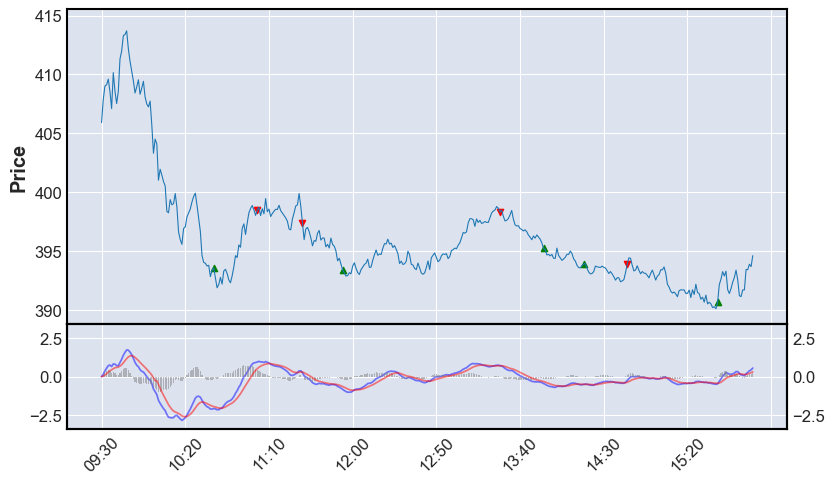

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from utils import cal_macd

def plot_trade_history(df, trade_history):
    """
    :params
    df: quote of stock
    """
    histories = pd.DataFrame(trade_history)
    histories['date'] = pd.to_datetime(histories['date'])
    histories.set_index('date', inplace=True)

    # 将信号合并到主数据框
    df.set_index('date', inplace=True, drop=False)
    # print(df)
    print(histories)
    df['direction'] = histories['direction']

    # 提取买卖点的索引和价格
    buy_signals = df[df['direction'] == 'Bought']
    sell_signals = df[df['direction'] == 'Sold']
    
    buy_signals_position = [df.index.get_loc(idx) for idx in buy_signals.index]
    sell_signals_position = [df.index.get_loc(idx) for idx in sell_signals.index]
    
    # 使用TA-Lib计算MACD
    df['DIF'], df['DEA'], df['MACD'] = cal_macd(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)

    fig, axes = mpf.plot(df, type='line', ylabel='Price', 
            addplot=[
                mpf.make_addplot(df['DIF'], panel=1, color='b', alpha=0.5),
                mpf.make_addplot(df['DEA'], panel=1, color='r', alpha=0.5),
                mpf.make_addplot(df['MACD'], panel=1, color='grey', type='bar', width=0.7, alpha=0.5)
            ],
            panel_ratios=(3, 1),  # 设置主图和副图的比例
            volume=False,         # 不显示成交量
            figsize=(10, 6),
            returnfig=True)       # 返回figure和axes对象


    # 在主图上标注买卖点
    ax_main = axes[0]  # 主图的Axes对象
    ax_main.scatter(buy_signals_position, buy_signals['close'], label='Buy', color='green', marker='^', s=20)
    ax_main.scatter(sell_signals_position, sell_signals['close'], label='Sell', color='red', marker='v', s=20)

    macd_range = max(abs(df['DIF'].min()), abs(df['DIF'].max())) * 1.2
    macd_ylim = (-1 * macd_range, macd_range)
    for panel_id in range(1, 4):
        axes[panel_id].set_ylim(macd_ylim)

    # 显示图像
    plt.show()
df = structure.data.set_index('date', inplace=True, drop=False)
plot_trade_history(structure.data, pm.trade_log)
